<a href="https://colab.research.google.com/github/mariusbiteau/Ecommerce-Customer-Segmentation/blob/main/Segmentation_Ecommerce_Customer_Segmentation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Commerce Customer Segmentation for a Brazilian marketplace (Olist)

Olist would like you to provide its e-commerce teams with a customer segmentation that they can use on a daily basis for their communication campaigns.

### About the Dataset

The dataset includes 100k orders from 2016 to 2018 with several brands in Brazil. The data includes the following information: price, valuation, number of items, weight, description, geolocation...

### Project Goal

Help Olist teams understand the different types of users.
I will use unsupervised methods to group together clients with similar profiles. These categories can be used by the marketing team to better communicate.

For reasons of confidentiality, Olist does not provide a lot of data, so it is up to you to dig into the data you have and create the best features to exploit them.

Finally, your client, Olist, has specified his request as follows:

- The proposed segmentation must be exploitable and easy to use for the marketing team.
- You will evaluate how often the segmentation needs to be updated, in order to be able to quote for a maintenance contract.
- The code provided must comply with the PEP8 convention in order to be usable by Olist.


In [30]:
# Essentials
from google.colab import drive
import pandas as pd
import numpy as np
import json
import time
import six
import datetime as dt

# Plots
import seaborn as sns
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Stats
import math
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from IPython.display import Image

from google.colab import drive

pd.options.display.max_columns = None
plt.style.use("default")

## 1. Data Import

In [4]:
drive.mount('/content/drive', force_remount=True)
csv_olist = '/content/drive/My Drive/OC_DataScientist/P5/df_olist_modelization.csv'
df = pd.read_csv(csv_olist)

Mounted at /content/drive


## 2. Data Description

In [5]:
df.head(3)

,Unnamed: 0,order_id,order_status,order_purchase_timestamp,delay_delivery,period,customer_unique_id,n_item,product_category_name_english,product_photos_qty,product_description_lenght,order_amount,freight_amount,n_payment,prefered_payment,n_payment_type,total_paid,review_score,delivery_respect,order_purchase_month,cohort_month,cohort_index,ratio_freight_amount
0,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7 days 02:34:47,2017-Q4,7c396fd4830fd04220f754e42b4e5bff,1.0,housewares,4.0,268.0,29.99,8.72,3.0,voucher,2.0,38.71,4,2,2017-10-01 00:00:00,2017-09-01 00:00:00,2,0.23
1,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,5 days 08:32:15,2018-Q3,af07308b275d755c9edb36a90c618231,1.0,perfumery,1.0,178.0,118.70,22.76,1.0,boleto,1.0,141.46,4,2,2018-07-01 00:00:00,2018-07-01 00:00:00,1,0.16
2,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,17 days 05:53:31,2018-Q3,3a653a41f6f9fc3d2a113cf8398680e8,1.0,auto,1.0,232.0,159.90,19.22,1.0,credit_card,1.0,179.12,5,2,2018-08-01 00:00:00,2018-08-01 00:00:00,1,0.11


##### Show data info


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98354 entries, 0 to 98353
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     98354 non-null  int64  
 1   order_id                       98354 non-null  object 
 2   order_status                   98354 non-null  object 
 3   order_purchase_timestamp       98354 non-null  object 
 4   delay_delivery                 96204 non-null  object 
 5   period                         98354 non-null  object 
 6   customer_unique_id             98354 non-null  object 
 7   n_item                         98354 non-null  float64
 8   product_category_name_english  98354 non-null  object 
 9   product_photos_qty             98354 non-null  float64
 10  product_description_lenght     98354 non-null  float64
 11  order_amount                   98354 non-null  float64
 12  freight_amount                 98354 non-null 

##### Fix data types


In [7]:
df['order_purchase_timestamp'] = \
    pd.to_datetime(df['order_purchase_timestamp'],
                   format="%Y-%m-%d %H:%M:%S")

Now, let's check our new data types and column names:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98354 entries, 0 to 98353
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     98354 non-null  int64         
 1   order_id                       98354 non-null  object        
 2   order_status                   98354 non-null  object        
 3   order_purchase_timestamp       98354 non-null  datetime64[ns]
 4   delay_delivery                 96204 non-null  object        
 5   period                         98354 non-null  object        
 6   customer_unique_id             98354 non-null  object        
 7   n_item                         98354 non-null  float64       
 8   product_category_name_english  98354 non-null  object        
 9   product_photos_qty             98354 non-null  float64       
 10  product_description_lenght     98354 non-null  float64       
 11  order_amount   

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [8]:
df.describe()

,Unnamed: 0,n_item,product_photos_qty,product_description_lenght,order_amount,freight_amount,n_payment,n_payment_type,total_paid,review_score,delivery_respect,cohort_index,ratio_freight_amount
count,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000
mean,49715.180460,1.141591,2.216392,782.432052,137.684871,22.820752,1.044462,1.022592,160.534034,4.090784,1.876741,1.094373,0.208785
std,28704.079645,0.538099,1.752826,656.244139,210.683379,21.656041,0.379175,0.148599,220.521254,1.342569,0.389599,0.849880,0.125751
min,0.000000,1.000000,0.000000,0.000000,0.850000,0.000000,1.000000,1.000000,9.590000,1.000000,0.000000,1.000000,0.000000
25%,24863.250000,1.000000,1.000000,341.000000,45.900000,13.850000,1.000000,1.000000,61.990000,4.000000,2.000000,1.000000,0.120000
50%,49714.500000,1.000000,1.000000,600.000000,86.900000,17.170000,1.000000,1.000000,105.280000,5.000000,2.000000,1.000000,0.180000
75%,74574.750000,1.000000,3.000000,987.000000,149.900000,24.030000,1.000000,1.000000,176.830000,5.000000,2.000000,1.000000,0.280000
max,99440.000000,21.000000,20.000000,3992.000000,13440.000000,1794.960000,29.000000,2.000000,13664.080000,5.000000,2.000000,20.000000,0.960000


## 2. RFM

#### 2.1 Setup

The target to be segmented being the customers, it is necessary to group the orders by customers.

To build the RFM metrics and have something consistent, I place myself as if the data were recent, at the beginning of Q4 2018.

In [11]:
df.order_purchase_timestamp.max()


Timestamp('2018-09-03 09:06:57')

In [12]:
date = df.order_purchase_timestamp.max() + dt.timedelta(days=2)
snapshot_date = date.replace(hour=0, minute=0, second=0)
snapshot_date

Timestamp('2018-09-05 00:00:00')

- For the Recency metric, I calculate the difference between the snapshot date and the most recent order date, in number of days.
- For the Frequency metric, I count the number of orders.
- For the MonetaryValue metric, I take into account the value of the product, without shipping costs. If a customer to purchase multiple products, whether in the same order or multiple orders, I sum the values of the products

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98354 entries, 0 to 98353
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     98354 non-null  int64         
 1   order_id                       98354 non-null  object        
 2   order_status                   98354 non-null  object        
 3   order_purchase_timestamp       98354 non-null  datetime64[ns]
 4   delay_delivery                 96204 non-null  object        
 5   period                         98354 non-null  object        
 6   customer_unique_id             98354 non-null  object        
 7   n_item                         98354 non-null  float64       
 8   product_category_name_english  98354 non-null  object        
 9   product_photos_qty             98354 non-null  float64       
 10  product_description_lenght     98354 non-null  float64       
 11  order_amount   

In [15]:
aggdict = {'order_id': 'count',
           'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
           'delivery_respect': lambda x: x.value_counts().index[0],
           'n_item': lambda x: x.value_counts().index[0],
           'product_category_name_english': lambda x: x.value_counts().index[0],
           'product_photos_qty': lambda x: x.value_counts().index[0],
           'product_description_lenght': lambda x: x.value_counts().index[0],
           'ratio_freight_amount': 'mean',
           'prefered_payment': lambda x: x.value_counts().index[0],
           'total_paid': 'sum',
           'review_score': lambda x: x.value_counts().index[0]}


customer = df.groupby('customer_unique_id').agg(aggdict)

columns_rename = {'order_purchase_timestamp': 'recency',
                  'order_id': 'frequency',
                  'total_paid': 'monetary_value'}

customer.rename(columns=columns_rename, inplace=True)

customer

,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5
...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,health_beauty,1.0,534.0,0.24,credit_card,2067.42,5
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,baby,2.0,506.0,0.23,credit_card,84.58,4
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,auto,5.0,716.0,0.20,credit_card,112.46,5


In [39]:
print("The number of customers to have order more than one time is : {:.2f} %"
      .format(100*sum(customer["frequency"] > 1)/len(customer)))

The number of customers to have order more than one time is : 3.05 %


In [16]:
customer_RFM = customer.copy()

#### 2.2 Segmentation

In [17]:
# Construction des segments
# Je définis R et M en fonction des 4 Quantiles
# Je définis F en fonction du nombre de fois ou les client a commandé
# A savoir je groupe les client qui ont commandé 4 fois et plus
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_quartiles = pd.qcut(customer_RFM['recency'], 4, labels=r_labels)
m_quartiles = pd.qcut(customer_RFM['monetary_value'], 4, labels=m_labels)

customer_RFM = customer_RFM.assign(R=r_quartiles.values)

customer_RFM['F'] = customer_RFM.frequency
customer_RFM['F'][customer_RFM.frequency > 3] = 4

customer_RFM = customer_RFM.assign(M=m_quartiles.values)

customer_RFM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M
customer_unique_id,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4,4,1,1
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4,2,1,1
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,health_beauty,1.0,534.0,0.24,credit_card,2067.42,5,1,1,4
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,baby,2.0,506.0,0.23,credit_card,84.58,4,2,1,2
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,auto,5.0,716.0,0.20,credit_card,112.46,5,1,1,3


In [19]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

In [20]:
customer_RFM['RFM_Segment'] = customer_RFM.apply(join_rfm, axis=1)
customer_RFM['RFM_Score'] = customer_RFM[['R', 'F', 'M']].sum(axis=1)
customer_RFM

,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5,4,1,3,413,8
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4,4,1,1,411,6
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3,1,1,2,112,4
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4,2,1,1,211,4
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5,2,1,4,214,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,health_beauty,1.0,534.0,0.24,credit_card,2067.42,5,1,1,4,114,6
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,baby,2.0,506.0,0.23,credit_card,84.58,4,2,1,2,212,5
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,auto,5.0,716.0,0.20,credit_card,112.46,5,1,1,3,113,5


#### 2.3 Analysis 1

In [21]:
# 10 premiers segments les plus peuplés
customer_RFM.groupby('RFM_Segment').size().\
    sort_values(ascending=False).head(10)

RFM_Segment
112    6120
111    6064
212    5976
311    5973
413    5949
313    5931
411    5905
211    5805
312    5718
213    5711
dtype: int64

In [22]:
# Valeur des segments
agg_dict = {'recency': 'mean',
            'frequency': 'mean',
            'monetary_value': 'mean',
            'customer_unique_id': 'count'}

score_RFM = customer_RFM.reset_index().groupby('RFM_Score')\
                        .agg(agg_dict).round(1)

In [23]:
score_RFM

,recency,frequency,monetary_value,customer_unique_id
RFM_Score,,,,
3,458.1,1.0,43.7,6064
4,368.9,1.0,64.2,11938
5,301.0,1.0,87.6,17489
6,241.1,1.0,163.6,23030
7,177.5,1.0,203.3,17574
8,122.9,1.1,258.9,12168
9,74.0,1.1,394.9,6253
10,75.6,2.1,397.6,517
11,87.7,3.5,569.3,65


#### 2.3 Analysis 2

Each customer is characterized according to the score for each variable R, F M which characterizes it

9 segments are defined :

- Champions: recent purchases, buys often and spends a lot
- Loyal Customers: buy regularly, sensitive to promotions
- Potential Loyalist: new customers with average purchase frequency
- Recent Customers: recent but infrequent purchases
- Promising: new buyers, but low spenders
- Need Attention: medium spending, medium frequency, medium recent purchase
- About to Sleep : customers who tend to disappear
- Can't Lose Them: buy regularly, need to get them back
- At Risk: Spent a lot, bought often but long ago
- Lost: low spend, low attendance, bought a while ago
- Others: not categorizable

In [40]:
categories_1 = ["Champions",
                "Loyal Customers",
                "Potential Loyalist",
                "Recent Customers",
                "Promising",
                "Need Attention",
                "About to Sleep",
                "Can't Lose Them",
                "At Risk",
                "Lost",
                "Others"]

In [41]:
def calculate_segments(customer_RFM):
    """
    Retourne le segment associé au client en fonction de son score pour les
    variables R, F et M

    Paramètres:
    rfm(pd.DataFrame): doit contenir les colonnes R, F et M

    Return:
    str: Nom du segment
    """

    if 4 <= customer_RFM["R"] <= 5 and 4 <= customer_RFM["F"] <= 5 and 4 <= customer_RFM["M"] <= 5:
        return "Champions"

    elif 3 <= customer_RFM["R"] <= 5 and 3 <= customer_RFM["F"] <= 5 and 2 <= customer_RFM["M"] <= 5:
        return "Loyal Customers"

    elif 3 <= customer_RFM["R"] <= 5 and 1 <= customer_RFM["F"] <= 3 and 1 <= customer_RFM["M"] <= 3:
        return "Potential Loyalist"

    elif customer_RFM["R"] >= 4 and customer_RFM["F"] <= 2:
        return "Recent Customers"

    elif 3 <= customer_RFM["R"] <= 4 and customer_RFM["F"] <= 1 and customer_RFM["M"] <= 1:
        return "Promising"

    elif 2 <= customer_RFM["R"] <= 3 and 2 <= customer_RFM["F"] <= 3 and 2 <= customer_RFM["M"] <= 3:
        return "Need Attention"

    elif 2 <= customer_RFM["R"] <= 3 and customer_RFM["F"] <= 2 and customer_RFM["M"] <= 2:
        return "About to Sleep"

    elif customer_RFM["R"] <= 1 and 4 <= customer_RFM["F"] <= 5 and 4 <= customer_RFM["M"] <= 5:
        return "Can't Lose Them"

    elif customer_RFM["R"] <= 2 and 2 <= customer_RFM["F"] <= 5 and 2 <= customer_RFM["M"] <= 5:
        return "At Risk"

    elif customer_RFM["R"] <= 2 and customer_RFM["F"] <= 2 and customer_RFM["M"] <= 2:
        return "Lost"

    else:
        return "Others"


In [42]:
# RFM Score
customer_RFM["RFM Score"] = customer_RFM.apply(calculate_segments, axis=1)

In [43]:
# Affiche les 5 premières lignes
customer_RFM.head()

,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score,RFM Score
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5,4,1,3,413,8,Potential Loyalist
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4,4,1,1,411,6,Potential Loyalist
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3,1,1,2,112,4,Lost
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4,2,1,1,211,4,About to Sleep
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5,2,1,4,214,7,Others


## 3. K-Means segmentation

During the EDA, I found that the customers didn't come back to Olist. I will focus my segmentation based on customer statifaction and RFM metrics.

In [24]:
col_list = ['recency',
            'frequency',
            'monetary_value',
            'review_score',
            'delivery_respect']

customer_km = customer[col_list].copy()

customer_km.head()

,recency,frequency,monetary_value,review_score,delivery_respect
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90,5,2
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19,4,2
0000f46a3911fa3c0805444483337064,543,1,86.22,3,2
0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62,4,2
0004aac84e0df4da2b147fca70cf8255,294,1,196.89,5,2


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

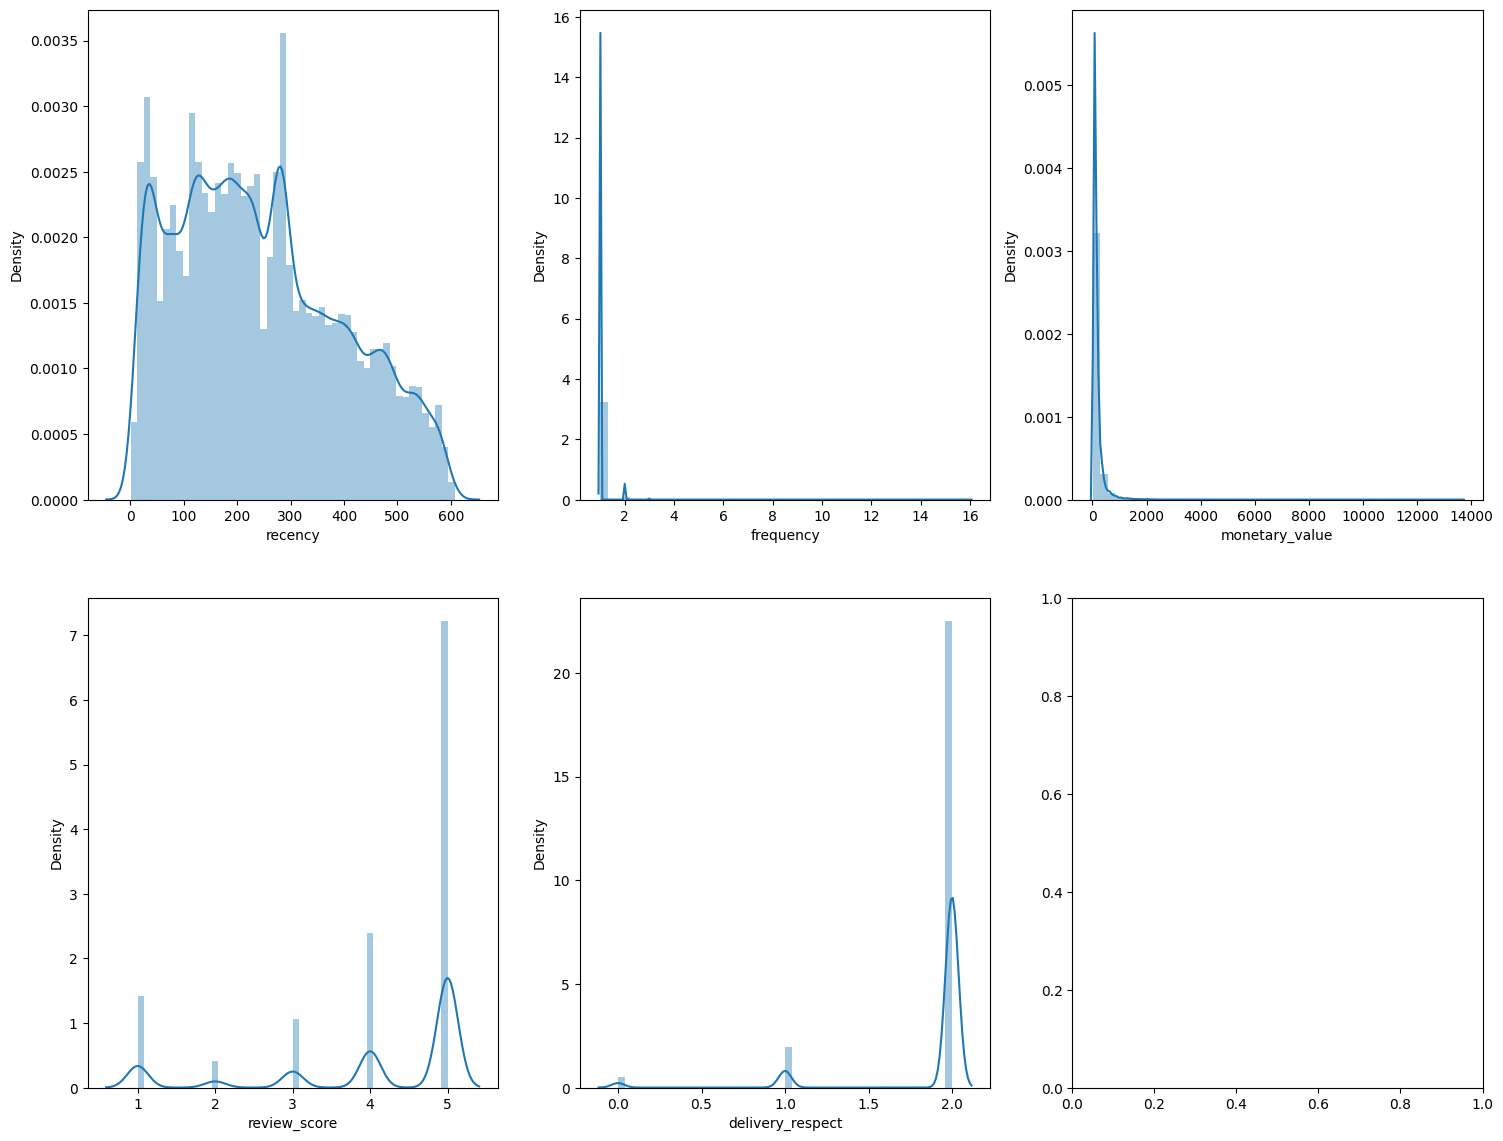

In [31]:
def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(customer_km, ["recency","frequency", "monetary_value", "review_score", "delivery_respect"])


matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]

In [32]:
customer_km.var().sort_values(ascending=False)

monetary_value      52158.720613
recency             22884.088140
review_score            1.807552
delivery_respect        0.148957
frequency               0.044608
dtype: float64

In [34]:
log_customer_km = customer_km.copy()

list = ['recency', 'frequency', 'monetary_value']
for i in list:
    log_customer_km[i + '_log'] = np.log(customer_km[i])
    log_customer_km.drop(i, axis=1, inplace=True)

In [35]:
scaler = StandardScaler()
std_customer_km = scaler.fit_transform(log_customer_km)

std_customer_km = pd.DataFrame(std_customer_km,
                               index=log_customer_km.index,
                               columns=log_customer_km.columns)
std_customer_km

,review_score,delivery_respect,recency_log,frequency_log,monetary_value_log
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.678837,0.313579,-0.514995,-0.173656,0.287637
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.064965,0.313579,-0.485920,-0.173656,-1.731518
0000f46a3911fa3c0805444483337064,-0.808766,0.313579,1.247710,-0.173656,-0.321211
0000f6ccb0745a6a4b88665a16c9f078,-0.064965,0.313579,0.665305,-0.173656,-1.153897
0004aac84e0df4da2b147fca70cf8255,0.678837,0.313579,0.543139,-0.173656,0.687885
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.678837,0.313579,1.039602,-0.173656,3.561420
fffea47cd6d3cc0a88bd621562a9d061,-0.064965,0.313579,0.436806,-0.173656,-0.344680
ffff371b4d645b6ecea244b27531430a,0.678837,0.313579,1.311469,-0.173656,0.003481


### 3.2. Clusters Definition

2 methods exist to define the number of clusters:

- Visual method with Elbow criterion
- Mathematical method with silhouette

Text(0.5, 1.0, 'Elbow Method For Optimal k')

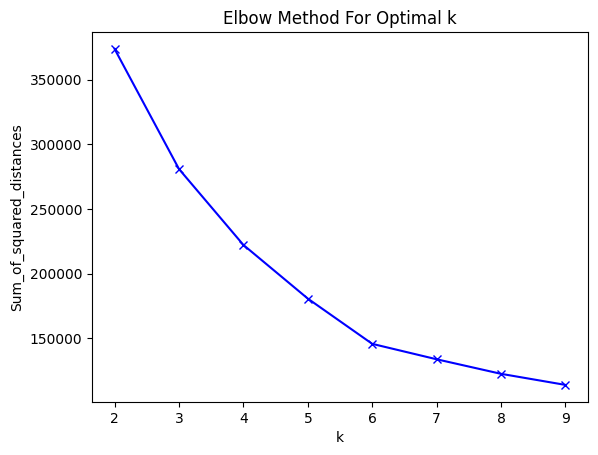

In [37]:
# Elbow
Sum_of_squared_distances = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(std_customer_km)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')


In [38]:
# Silhouette
silhouette = []
K = range(2, 10)
for k in K:
    print(f'Nb of cluster in process :  {k}')
    km = KMeans(n_clusters=k)
    km = km.fit(std_customer_km)
    score = round(silhouette_score(std_customer_km, km.labels_), 2)
    silhouette.append(score)

silh_dict = {'Number of cluster': K,
             'Silhouette Score': silhouette}
silhouette_df = pd.DataFrame(data=silh_dict)
silhouette_df

Nb of cluster in process :  2
Nb of cluster in process :  3
Nb of cluster in process :  4
Nb of cluster in process :  5
Nb of cluster in process :  6
Nb of cluster in process :  7
Nb of cluster in process :  8
Nb of cluster in process :  9


,Number of cluster,Silhouette Score
0,2,0.45
1,3,0.44
2,4,0.32
3,5,0.29
4,6,0.32
5,7,0.29
6,8,0.30
7,9,0.29


In [ ]:
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(std_customer_km)
cluster_labels = kmeans.labels_

### 3.2. Centroids

In [ ]:
# Intégration des centroïdes dans un dataframe
ctds = pd.DataFrame(kmeans.cluster_centers_,
                    columns=std_customer_km.columns)
ctds = ctds.reset_index().rename(columns={'index': 'cluster'})
ctds

In [ ]:
# Intégration des centroïdes dans un dataframe
ctds = pd.DataFrame(kmeans.cluster_centers_,
                    columns=std_customer_km.columns)
ctds = ctds.reset_index().rename(columns={'index': 'cluster'})

# Récupération des spécificités des centroïdes
several_orders = ctds.sort_values(by='frequency_log')\
                        .tail(1).cluster.iloc[0]

recent_order = ctds.sort_values(by='monetary_value_log')\
                    .head(2).cluster.iloc[1]

low_value = ctds.sort_values(by='monetary_value_log')\
                .head(1).cluster.iloc[0]

c_fix = ['delivery_respect', 'review_score']
ctds['fix_customer'] = ctds[c_fix].sum(axis=1)
bad_score = ctds.sort_values(by='fix_customer')\
                .head(2).cluster.iloc[1]

ctds['fix_customer'] = ctds[c_fix].sum(axis=1)
bad_delivery = ctds.sort_values(by='fix_customer')\
                    .head(1).cluster.iloc[0]

c_top = ['review_score', 'monetary_value_log']
ctds['top_customer'] = ctds[c_top].sum(axis=1)
top_customer = ctds.sort_values(by='top_customer')\
                    .tail(1).cluster.iloc[0]

# Création du dictionnaire des cluster
dict_cluster = {'2.Client actif': several_orders,
                '5.Client non livré/en retard': bad_delivery,
                '6.Client mécontent': bad_score,
                '3.Client récent': recent_order,
                '4.Client à faible valeur': low_value,
                '1.Top client': top_customer}

ctds['cluster_name'] = np.nan

for i, n in dict_cluster.items():
    ctds['cluster_name'][ctds.cluster == n] = i

round(ctds, 2)

In [ ]:
ctds.drop(columns=['fix_customer', 'top_customer'], inplace=True

In [ ]:
std_customer_km = affect_cluster_name(std_customer_km,
                                      cluster_labels,
                                      dict_cluster)
std_customer_km.head()